#### Setup

In [ ]:
! pip install transformers

In [ ]:
# Install Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

In [3]:
import contextlib
from google.colab import files
import io

with contextlib.redirect_stdout(io.StringIO()):
    files.upload()

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c AI4Code

!  unzip /content/AI4Code.zip -d /content/data

! rm -rf /content/AI4Code.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/f6db191d381f4d.json  
  inflating: /content/data/train/f6db2ed8b2f4bb.json  
  inflating: /content/data/train/f6dde9e2e8eb86.json  
  inflating: /content/data/train/f6de7eb809cf27.json  
  inflating: /content/data/train/f6df1dc0c85787.json  
  inflating: /content/data/train/f6df3902ed7d54.json  
  inflating: /content/data/train/f6dfd1a9ba9952.json  
  inflating: /content/data/train/f6e01d075510b5.json  
  inflating: /content/data/train/f6e02a07a0ee59.json  
  inflating: /content/data/train/f6e09f73640e87.json  
  inflating: /content/data/train/f6e106ebc8b741.json  
  inflating: /content/data/train/f6e10957cb4896.json  
  inflating: /content/data/train/f6e111cb5f68e7.json  
  inflating: /content/data/train/f6e13748676d1b.json  
  inflating: /content/data/train/f6e21be8c7b236.json  
  inflating: /content/data/train/f6e2f5c7b69ef4.json  
  inflating: /content/data/train/f6e37021a4229d.json  
  inflating: /

### Imports and Globals

In [6]:
import json
from pathlib import Path
import os
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

BERT_PATH = Path('/content/distil_bert_uncased')

os.makedirs(BERT_PATH, exist_ok=True)

data_dir = Path('/content/data')

### Read input data

In [7]:
NUM_TRAIN = 10000


def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )


paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)

df

Train NBs: 100%|██████████| 10000/10000 [00:53<00:00, 188.12it/s]


cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
00058dc97eae4b 9edb9716      code  import pandas as pd\nimport numpy as np\n\n# Importing libraries for text preprocessing...\nfrom nltk.corpus import ...
               caa86438      code  # Taking a look at our data\ndata = pd.read_csv('../input/are-two-sentences-of-the-same-topic/train.csv').drop(colum...
               0c219582      code                                                  # The dataset is balanced, fortunately\ndata.same_source.value_counts()
               f602e64e      code  # Let's clean our data from stopwords and truncate the word endings to make the different forms\n# of one word repre...
               29e7cac1      code                                                                                                    # Cleaned texts\ndata
...                           ...                                                                                                                      ...
fffc1b4f08e81c f49cf481      code  new_df  = df[['all_topics_keyword_gaps_Avg_traffic_parameter_2', 'all_topics_buyer_keywords_Avg_traffic_parameter_3'...
               ae8f2eb5      code  ### find perfect theta_0 and theta_1\n\ntheta_0 = -5.0625;\ntheta_1 = 0.20625;\ny_pred = theta_0 + theta_1*new_df['a...
               df457077      code  plt.scatter(new_df['all_topics_buyer_keywords_Avg_traffic_parameter_3'], new_df['all_topics_keyword_gaps_Avg_traffic...
               143cccfb  markdown                                                                                                  # Predict model in line
               ffc27279  markdown                                                                                                                     ****

[453869 rows x 2 columns]

Let's analyse an example notebook.

* df created above contains all the commands (disordered)
* Order df (train_orders.csv) contains the order of the cells in the notebooks

In [8]:
nb_id = df.index.unique('id')[6]
print('Notebook:', nb_id)

print("The disordered notebook:")
nb = df.loc[nb_id, :]
display(nb)
print()

Notebook: 0013a8634c4d8a
The disordered notebook:


,cell_type,source
cell_id,,
c289aa69,code,# basic library\nimport numpy as np\nimport pandas as pd\nimport warnings\nwarnings.filterwarnings('ignore')\n\n# vi...
a90dd013,code,train = pd.read_csv('../input/digit-recognizer/train.csv')\ntest = pd.read_csv('../input/digit-recognizer/test.csv')...
663637c5,code,print(f'train shape : {train.shape}')\nprint(f'test shape : {test.shape}')
8fc13ce3,code,"X_train = train.drop(['label'], axis=1)\ny_train = train['label']"
7c16654b,code,"# label histogram\nsns.countplot(x='label', data=train)"
390da637,code,X_train /= 255.0\ntest /= 255.0
dfa019e9,code,"X_train1 = X_train.values.reshape(-1, 28, 28, 1)\ntest = test.values.reshape(-1, 28, 28, 1)"
2a4e2c42,code,"from keras.utils.np_utils import to_categorical\ny_train = to_categorical(y_train, num_classes=10)"
c9b65248,code,"X_train, X_val , y_train, y_val = train_test_split(X_train1, y_train, test_size=0.2)"


In [9]:
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

df_orders

id
00001756c60be8    [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136...
00015c83e2717b    [2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c417225b, 51e3cd89, 2600b4eb, 75b65993, cf195f8b, 25699d02, 72b3201a, f2c75...
0001bdd4021779    [3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310c80, 073e27e5, 015d52a4, ad7679ef, 7fde4f04, 07c52510, 0a1a7a39, 0bcd3...
0001daf4c2c76d    [97266564, a898e555, 86605076, 76cc2642, ef279279, df6c939f, 2476da96, 00f87d0a, ae93e8e6, 58aadb1d, d20b0094, 986fd...
0002115f48f982                                 [9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe576, a3188e54, b3f6e12d, ee7655ca, 84125b7a]
                                                                           ...                                                           
fffc30d5a0bc46    [09727c0c, ff1ea6a0, ddfef603, a01ce9b3, 3ba953ee, bf92a015, f4a0492a, 095812e6, 53125cfe, aa32a700, 63340e73, 06d8c...
fffc3b44869198    [978a5137, fa

In [10]:
len(df_orders.loc[nb_id])

23

In [11]:
cell_order = df_orders.loc[nb_id]

print("The ordered notebook:")
nb.loc[cell_order, :]

The ordered notebook:


,cell_type,source
cell_id,,
c289aa69,code,# basic library\nimport numpy as np\nimport pandas as pd\nimport warnings\nwarnings.filterwarnings('ignore')\n\n# vi...
a37d3620,markdown,### import Data
a90dd013,code,train = pd.read_csv('../input/digit-recognizer/train.csv')\ntest = pd.read_csv('../input/digit-recognizer/test.csv')...
663637c5,code,print(f'train shape : {train.shape}')\nprint(f'test shape : {test.shape}')
8fc13ce3,code,"X_train = train.drop(['label'], axis=1)\ny_train = train['label']"
7c16654b,code,"# label histogram\nsns.countplot(x='label', data=train)"
ff8b3d59,markdown,### Normalization
390da637,code,X_train /= 255.0\ntest /= 255.0
7315e86f,markdown,### Reshape


Add rank to the cells in train_orders df

In [12]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

# testing the function on the above example train_order sample
cell_ranks = get_ranks(cell_order, list(nb.index))
nb.insert(0, 'rank', cell_ranks)

nb

,rank,cell_type,source
cell_id,,,
c289aa69,0,code,# basic library\nimport numpy as np\nimport pandas as pd\nimport warnings\nwarnings.filterwarnings('ignore')\n\n# vi...
a90dd013,2,code,train = pd.read_csv('../input/digit-recognizer/train.csv')\ntest = pd.read_csv('../input/digit-recognizer/test.csv')...
663637c5,3,code,print(f'train shape : {train.shape}')\nprint(f'test shape : {test.shape}')
8fc13ce3,4,code,"X_train = train.drop(['label'], axis=1)\ny_train = train['label']"
7c16654b,5,code,"# label histogram\nsns.countplot(x='label', data=train)"
390da637,7,code,X_train /= 255.0\ntest /= 255.0
dfa019e9,9,code,"X_train1 = X_train.values.reshape(-1, 28, 28, 1)\ntest = test.values.reshape(-1, 28, 28, 1)"
2a4e2c42,10,code,"from keras.utils.np_utils import to_categorical\ny_train = to_categorical(y_train, num_classes=10)"
c9b65248,11,code,"X_train, X_val , y_train, y_val = train_test_split(X_train1, y_train, test_size=0.2)"


Assign correct cell order rank in the df created from raw data

In [13]:
# Step 1 : Add correct cell order to df, using order in df_orders 
df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

# Step 2 - Get rank (here cell_order is base and cell_id retreived from df_orders is the derived)
ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

# Step 3 - Create a dataframe out of it
df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

df_ranks

rank
id             cell_id      
00058dc97eae4b 9edb9716    1
               caa86438    2
               0c219582    3
               f602e64e    4
               29e7cac1    5
...                      ...
fffc1b4f08e81c f49cf481   37
               ae8f2eb5   38
               df457077   39
               143cccfb   29
               ffc27279    0

[453869 rows x 1 columns]

Read in ancestors data

In [14]:
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df_ancestors

,ancestor_id,parent_id
id,,
00001756c60be8,945aea18,NaN
00015c83e2717b,aa2da37e,317b65d12af9df
0001bdd4021779,a7711fde,NaN
0001daf4c2c76d,090152ca,NaN
0002115f48f982,272b483a,NaN
...,...,...
fffc30d5a0bc46,6aed207b,NaN
fffc3b44869198,a6aaa8d7,NaN
fffc63ff750064,0a1b5b65,NaN


Merge ranks and ancestors to raw data

In [15]:
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id
0,00058dc97eae4b,9edb9716,code,import pandas as pd\nimport numpy as np\n\n# Importing libraries for text preprocessing...\nfrom nltk.corpus import ...,1,c54154f7,NaN
1,00058dc97eae4b,caa86438,code,# Taking a look at our data\ndata = pd.read_csv('../input/are-two-sentences-of-the-same-topic/train.csv').drop(colum...,2,c54154f7,NaN
2,00058dc97eae4b,0c219582,code,"# The dataset is balanced, fortunately\ndata.same_source.value_counts()",3,c54154f7,NaN
3,00058dc97eae4b,f602e64e,code,# Let's clean our data from stopwords and truncate the word endings to make the different forms\n# of one word repre...,4,c54154f7,NaN
4,00058dc97eae4b,29e7cac1,code,# Cleaned texts\ndata,5,c54154f7,NaN
...,...,...,...,...,...,...,...
453864,fffc1b4f08e81c,f49cf481,code,"new_df = df[['all_topics_keyword_gaps_Avg_traffic_parameter_2', 'all_topics_buyer_keywords_Avg_traffic_parameter_3'...",37,7c4554cd,NaN
453865,fffc1b4f08e81c,ae8f2eb5,code,### find perfect theta_0 and theta_1\n\ntheta_0 = -5.0625;\ntheta_1 = 0.20625;\ny_pred = theta_0 + theta_1*new_df['a...,38,7c4554cd,NaN
453866,fffc1b4f08e81c,df457077,code,"plt.scatter(new_df['all_topics_buyer_keywords_Avg_traffic_parameter_3'], new_df['all_topics_keyword_gaps_Avg_traffic...",39,7c4554cd,NaN
453867,fffc1b4f08e81c,143cccfb,markdown,# Predict model in line,29,7c4554cd,NaN


Is there any data skew?

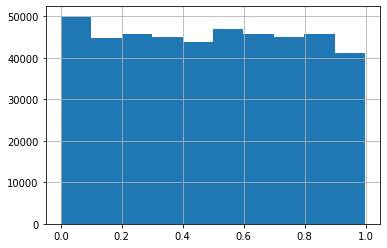

In [16]:
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

df["pct_rank"].hist(bins=10)

Doesn't look it!

Train-Valid Split

Since we want the entire notebook to be in either train or test split (or validation), we can use GroupShuffleSplit, using ancestor_id as per the data documentation

In [17]:
from sklearn.model_selection import GroupShuffleSplit

NVALID = 0.1  # size of validation set

splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)

train_ind, val_ind = next(splitter.split(df, groups=df["ancestor_id"]))

train_df = df.loc[train_ind].reset_index(drop=True)
val_df = df.loc[val_ind].reset_index(drop=True)

In [18]:
val_df.head()

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,00058dc97eae4b,9edb9716,code,import pandas as pd\nimport numpy as np\n\n# Importing libraries for text preprocessing...\nfrom nltk.corpus import ...,1,c54154f7,NaN,0.047619
1,00058dc97eae4b,caa86438,code,# Taking a look at our data\ndata = pd.read_csv('../input/are-two-sentences-of-the-same-topic/train.csv').drop(colum...,2,c54154f7,NaN,0.095238
2,00058dc97eae4b,0c219582,code,"# The dataset is balanced, fortunately\ndata.same_source.value_counts()",3,c54154f7,NaN,0.142857
3,00058dc97eae4b,f602e64e,code,# Let's clean our data from stopwords and truncate the word endings to make the different forms\n# of one word repre...,4,c54154f7,NaN,0.190476
4,00058dc97eae4b,29e7cac1,code,# Cleaned texts\ndata,5,c54154f7,NaN,0.238095


In [19]:
val_df["cell_type"].value_counts()

code        31306
markdown    16199
Name: cell_type, dtype: int64

In [20]:
train_df_mark = train_df[train_df["cell_type"] == "markdown"].reset_index(drop=True)

val_df_mark = val_df[val_df["cell_type"] == "markdown"].reset_index(drop=True)

### Competition Metrics

In [21]:
from bisect import bisect


def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

Test out the metrics on example

In [22]:
y_dummy = val_df.groupby('id')['cell_id'].apply(list)
kendall_tau(df_orders.loc[y_dummy.index], y_dummy)

0.3978209928043349

### Modelling

#### Download and Save Distil-BERT model

In [23]:
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer.save_pretrained(BERT_PATH)
model.save_pretrained(BERT_PATH)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Modelling imports and globals

In [24]:
from tqdm import tqdm
import sys, os
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

MAX_LEN = 128

In [25]:
class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_PATH)
        self.top = nn.Linear(768, 1)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = self.top(x[:, 0, :])
        return x

In [26]:
from torch.utils.data import DataLoader, Dataset


class MarkdownDataset(Dataset):
    '''
    Child DataSet class updating __getitem__ of the df and 
    replacing it to return Token ids, attention masks and percent rank
    '''
    
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

    def __getitem__(self, index):
        '''
        So, when we say data[1], the MarkdownDataset will return 
        Token ids, attention masks and percent rank of the index 1
        '''
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row.source,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]

In [27]:
train_ds = MarkdownDataset(train_df_mark, max_len=MAX_LEN)
val_ds = MarkdownDataset(val_df_mark, max_len=MAX_LEN)

val_ds[0]

(tensor([  101,  1996, 13229,  2015,  2041,  4842, 14192,  1996, 19875,  4523,
          1025,  2027,  4025,  2000,  2424,  2062,  3375,  4262,  2090,  1996,
         11746,  1012,  2036,  1010,  2039, 16616,  1996,  3653,  1011,  4738,
          7861,  8270,  4667,  2015,  2738,  2084, 11414,  1996,  2047,  3924,
          3445,  1996,  8740,  2278,  2013,  1014,  1012,  6255,  2000,  1014,
          1012,  6445,  1012,  2012,  1996,  2617,  1045,  1005,  1049,  2667,
          2000,  8579,  1996,  3471,  1997,  1996, 28667, 29264, 16996,  1012,
         11504,  2027,  1005,  2222,  3711,  2182,  2101,  1012,  1008,  1008,
          4283,  2005,  2115,  3086,   999,  1045,  1005,  1049,  2330,  2005,
          1037,  6594,  2065,  2017,  2215,  2000,  2681,  2151,  7928,  1012,
          1008,  1008,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

Adjusted Learning Rate and Optimizer

In [28]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer

Create batched data using DataLoader API

In [29]:
BS = 32
NW = 8

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
